# Linear Classification with Gradient Descent

In [78]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import data_handler as dh
from matplotlib import pyplot as plt

## Fetching and Pre-Processing the data

In [79]:
bank_marketing = fetch_ucirepo(id=222)
occupancy_detection = fetch_ucirepo(id=357)

X_bank_marketing, y_bank_marketing = bank_marketing.data.features, bank_marketing.data.targets
X_occupancy, y_occupancy = occupancy_detection.data.features, occupancy_detection.data.targets

Pre-process the bank marketing data. Drop features without values for prediction: month, day_of_week. We have to treat NaN values differently than last week, since dropping them would drastically reduce the instances of the data, so we replace them with 0. We use One-Hot encoding for non-numeric (categorical) values. We use min-max normalization to avoid huge values for residuals.

In [80]:
X_bank_marketing = X_bank_marketing.drop(['month', 'day_of_week'], axis=1)  # drop features without value for prediction

X_bank_marketing = X_bank_marketing.fillna(0)

X_bank_marketing = pd.get_dummies(X_bank_marketing).astype(np.float64)

X_bank_marketing = (X_bank_marketing - X_bank_marketing.min()) / (
        X_bank_marketing.max() - X_bank_marketing.min())  # normalize the data

y_bank_marketing.loc[:, 'y'] = y_bank_marketing['y'].map({'no': 0, 'yes': 1})  # convert targets to numeric values

Pre-process the occupancy data. Drop the date feature. Since all features are type object, we have to remove the standing out ones and convert them to numeric values. We use min-max normalization to avoid huge values for residuals.

In [81]:
X_occupancy = X_occupancy.drop(['date'], axis=1)  # drop features without value for prediction

X_occupancy = X_occupancy.apply(pd.to_numeric, errors='coerce').dropna().astype(
    np.float64)  # Convert all columns to numeric, coerce errors to NaN, and drop rows with NaN values

X_occupancy = (X_occupancy - X_occupancy.min()) / (X_occupancy.max() - X_occupancy.min())  # normalize the data

Split the datasets in training data and test data. We use our method from `data_handler`.

In [82]:
X_occupancy_train, X_occupancy_test, y_occupancy_train, y_occupancy_test = dh.split_data(X_occupancy,
                                                                                         y_occupancy, 0.8)
X_bank_marketing_train, X_bank_marketing_test, y_bank_marketing_train, y_bank_marketing_test = dh.split_data(
    X_bank_marketing, y_bank_marketing, 0.8)

## Implementation of Linear Classification

We use the negative log likelihood function, else we would have only negative loss values.
We use the epoch loss difference for convergence criterion


In [83]:
class LinearClassifierBoldDriver:
    def __init__(self):
        self.B = None

    def fit(self, X_train, y_train, X_test, y_test, i_max, tolerance=1e-6):
        """
        Fits the model using the stochastic gradient descent/ascend algorithm with Bold Driver for dynamic step length.
        :param X_train: Training input features.
        :param y_train: Training target values.
        :param X_test: Test input features for calculating the log-loss.
        :param y_test: Test target values for calculating the log-loss.
        :param i_max: Maximum number of iterations.
        :param tolerance: Improvement threshold for convergence.
        :return: Tuple of epoch loss difference history (|f(x_i-1 - f(x_i)|) and log-loss history on test set.
        """
        initial_learning_rate = 0.01
        alpha = 1.1
        beta = 0.5

        n = X_train.shape[0]
        d = X_train.shape[1]

        def SGD(f, grad_f):
            self.B = np.zeros(d)
            learning_rate = initial_learning_rate
            epoch_loss_diff = []
            test_loss_history = []

            for epoch in range(1, i_max + 1):
                indices = np.random.permutation(n)
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                prev_loss = f(X_train, y_train)

                for i in range(n):
                    x_i = X_shuffled[i]
                    y_i = y_shuffled[i]

                    gradient = grad_f(x_i, y_i)

                    self.B += learning_rate * gradient

                current_loss = f(X_train, y_train)
                loss_diff = abs(current_loss - prev_loss)
                epoch_loss_diff.append(loss_diff)

                test_loss = f(X_test, y_test)
                test_loss_history.append(test_loss)

                # bold driver for choosing the step length
                if current_loss < prev_loss:
                    learning_rate *= alpha
                else:
                    learning_rate *= beta

                if len(epoch_loss_diff) > 1 and epoch_loss_diff[-1] < tolerance:
                    print(f"Converged after {epoch} epochs.")
                    break
            else:
                print(f"WARNING: Not converged after {i_max} epochs.")
            return epoch_loss_diff, test_loss_history

        def log_likelihood(X, y):
            predictions = 1 / (1 + np.exp(-(X @ self.B)))
            return -np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions)) / X.shape[0]  # Normalized loss

        def grad_log_likelihood(x_i, y_i):
            sigmoid = 1 / (1 + np.exp(-(self.B.T @ x_i)))
            return (y_i - sigmoid) * x_i

        return SGD(log_likelihood, grad_log_likelihood)

    def predict(self, X):
        """
        Predicts the target values.
        :param X: Input features.
        :return: Predicted values.
        """
        if self.B is None:
            raise ValueError('The Model has not been trained yet. Please call fit() first.')

        sigmoid = 1 / (1 + np.exp(-(self.B.T @ X)))

        return (sigmoid >= 0.5).astype(np.int8)  # Threshold of 0.5 to convert to binary values


In [84]:
model_bank = LinearClassifierBoldDriver()
bank_eld, bank_tlh = model_bank.fit(X_bank_marketing_train, y_bank_marketing_train, X_bank_marketing_test,
                                    y_bank_marketing_test, 200, tolerance=1e-9)

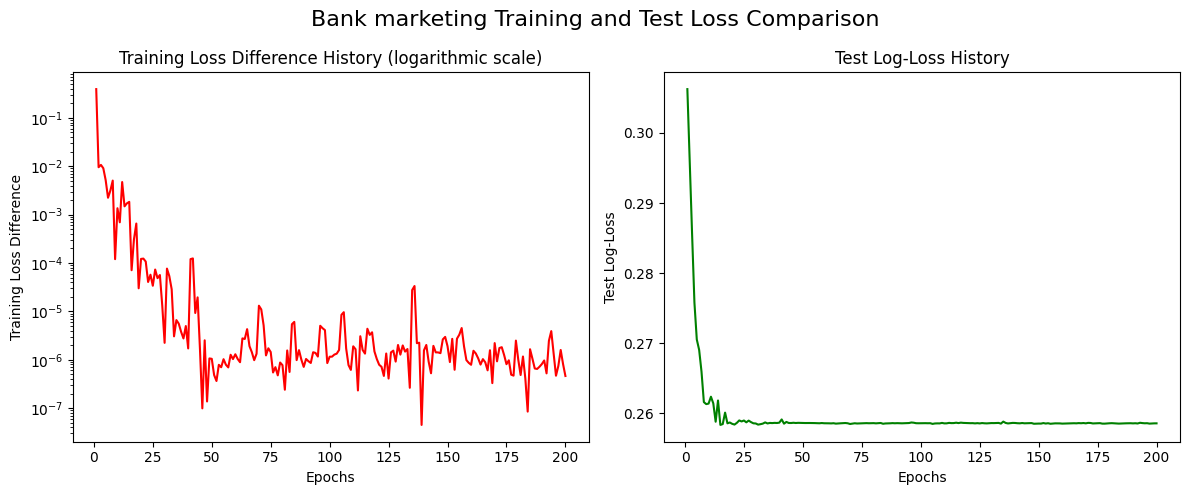

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(1, len(bank_eld) + 1), bank_eld, color="red")
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss Difference')
axes[0].set_yscale('log')
axes[0].set_title('Training Loss Difference History (logarithmic scale)')

axes[1].plot(range(1, len(bank_tlh) + 1), bank_tlh, color="green")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Test Log-Loss')
axes[1].set_title('Test Log-Loss History')

fig.suptitle('Bank marketing Training and Test Loss Comparison', fontsize=16)

plt.tight_layout()
plt.show()
plt.close()

We used a convergence threshold of 1e-9, wich is obviously too small. But based on these graphs, we can determine a suitable convergence threshold for future predictions.

In the Training Loss Difference History plot, significant improvement occurs until ~50th epoch. Beyond that, the training loss difference begins to oscillate around a value slightly below 1e-6. This suggests that a convergence threshold of 1e-6 would be a reasonable choice for future training.

The Test Log-Loss History plot supports this observation. After the initial phase of rapid improvement, the log-loss on the test set stabilizes with little further improvement. This indicates that, when the training loss difference reaches very small values, the model is no longer effectively minimizing the loss, meaning it has likely converged. Therefore, a threshold of 1e-6 appears to be an appropriate balance between convergence speed and model performance.

In [86]:
model_occupancy = LinearClassifierBoldDriver()
occupancy_eld, occupancy_tlh = model_occupancy.fit(X_occupancy_train, y_occupancy_train, X_occupancy_test,
                                                   y_occupancy_test, 200, tolerance=1e-6)

Converged after 76 epochs.


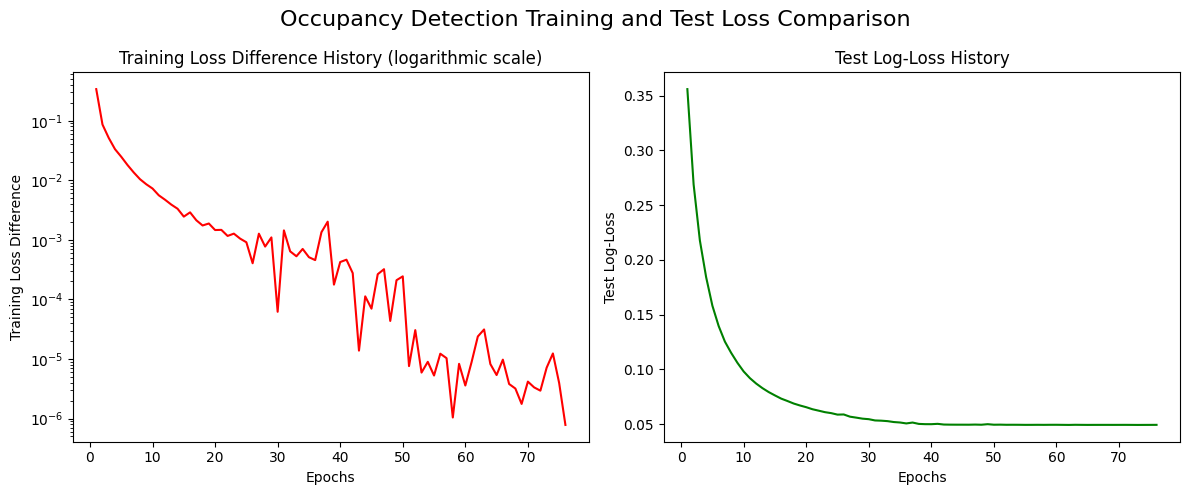

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(1, len(occupancy_eld) + 1), occupancy_eld, color="red")
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss Difference')
axes[0].set_yscale('log')
axes[0].set_title('Training Loss Difference History (logarithmic scale)')

axes[1].plot(range(1, len(occupancy_tlh) + 1), occupancy_tlh, color="green")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Test Log-Loss')
axes[1].set_title('Test Log-Loss History')

fig.suptitle('Occupancy Detection Training and Test Loss Comparison', fontsize=16)

plt.tight_layout()
plt.show()
plt.close()

Now, we use the convergence threshold of 1e-6, as discussed above.

In the Training Loss Difference History plot, the training loss difference consistently decreases until reaching the threshold. This behavior indicates that the model is effectively converging without unnecessary oscillations or plateauing at high loss values.

In the Test Log-Loss History plot, we observe a sharp decline in log-loss in the initial epochs, followed by a gradual stabilization. The rapid reduction in the first 10 epochs suggests that the model learns quickly at the beginning, capturing most of the predictive patterns. The subsequent stabilization indicates that, after this point, further training results in only minimal improvements. This behavior validates the choice of a convergence threshold of 1e-6, as it prevents long training with very small or no improvements.

Overall, the model with the updated threshold of 1e-6 results in a balanced and efficient convergence, providing both quick training and stable test performance.

# AdaGrad for Adaptive Step Length

In this exercise, we implement another Linear Classifier that uses AdaGrad for Adaptive Step Length. We use the algorithm from https://www.ismll.uni-hildesheim.de/lehre/opt-16w/script/mot-03_sgd.pdf, as suggested in the moodle forum by Moritz.

## Implementation

The key difference is that AdaGrad adjusts the step size individually for each parameter. For each parameter, we use the formula $\mu_n = \frac{\mu_0}{\sqrt{h_n}}$.

Since the model is more dependent on the initial learning rate, we added it as an optional parameter.

Most of the code is the same as above, but creating a separate class for the AdaGrad-based classifier helps maintain clarity. It provides a clear structure that follows the tasks from the exercise sheet.

In [88]:
class LinearClassifierAdaGrad:
    def __init__(self):
        self.B = None

    def fit(self, X_train, y_train, X_test, y_test, i_max, initial_learning_rate=0.01, tolerance=1e-6):
        """
        Fits the model using the stochastic gradient descent/ascend algorithm with AdaGrad for dynamic step length.
        :param X_train: Training input features.
        :param y_train: Training target values.
        :param X_test: Test input features for calculating the log-loss.
        :param y_test: Test target values for calculating the log-loss.
        :param i_max: Maximum number of iterations.
        :param initial_learning_rate: Initial learning rate for AdaGrad.
        :param tolerance: Improvement threshold for convergence.
        :return: Tuple of epoch loss difference history (|f(x_i-1 - f(x_i)|) and log-loss history on test set.
        """
        n = X_train.shape[0]
        d = X_train.shape[1]
        epsilon = 1e-8  # Constant to avoid division by zero

        def SGD(f, grad_f):
            self.B = np.zeros(d)
            gradient_history = np.zeros(d)
            epoch_loss_diff = []
            test_loss_history = []

            for epoch in range(1, i_max + 1):
                indices = np.random.permutation(n)
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                prev_loss = f(X_train, y_train)

                #  AdaGrad
                for i in range(n):
                    x_i = X_shuffled[i]
                    y_i = y_shuffled[i]

                    gradient = grad_f(x_i, y_i)

                    gradient_history += gradient ** 2

                    adjusted_learning_rate = initial_learning_rate / (np.sqrt(gradient_history) + epsilon)
                    self.B += adjusted_learning_rate * gradient

                current_loss = f(X_train, y_train)
                loss_diff = abs(current_loss - prev_loss)
                epoch_loss_diff.append(loss_diff)

                test_loss = f(X_test, y_test)
                test_loss_history.append(test_loss)

                if len(epoch_loss_diff) > 1 and epoch_loss_diff[-1] < tolerance:
                    print(f"Converged after {epoch} epochs.")
                    break
            else:
                print(f"WARNING: Not converged after {i_max} epochs.")
            return epoch_loss_diff, test_loss_history

        def log_likelihood(X, y):
            predictions = 1 / (1 + np.exp(-(X @ self.B)))
            return -np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions)) / X.shape[0]  # Normalized loss

        def grad_log_likelihood(x_i, y_i):
            sigmoid = 1 / (1 + np.exp(-(self.B.T @ x_i)))
            return (y_i - sigmoid) * x_i

        return SGD(log_likelihood, grad_log_likelihood)

    def predict(self, X):
        """
        Predicts the target values.
        :param X: Input features.
        :return: Predicted values.
        """
        if self.B is None:
            raise ValueError('The Model has not been trained yet. Please call fit() first.')

        sigmoid = 1 / (1 + np.exp(-(self.B.T @ X)))

        return (sigmoid >= 0.5).astype(np.int8)  # Threshold of 0.5 to convert to binary values

### Evaluation with Bank Marketing Data

In [89]:
model_bank_ada_grad = LinearClassifierAdaGrad()
bank_eld_ada_grad_1, bank_tlh_ada_grad_1 = model_bank_ada_grad.fit(X_bank_marketing_train, y_bank_marketing_train,
                                                                   X_bank_marketing_test, y_bank_marketing_test, 200,
                                                                   initial_learning_rate=1, tolerance=1e-6)

bank_eld_ada_grad_05, bank_tlh_ada_grad_05 = model_bank_ada_grad.fit(X_bank_marketing_train, y_bank_marketing_train,
                                                                     X_bank_marketing_test, y_bank_marketing_test, 200,
                                                                     initial_learning_rate=0.5, tolerance=1e-6)

bank_eld_ada_grad_01, bank_tlh_ada_grad_01 = model_bank_ada_grad.fit(X_bank_marketing_train, y_bank_marketing_train,
                                                                     X_bank_marketing_test, y_bank_marketing_test, 200,
                                                                     initial_learning_rate=0.1, tolerance=1e-6)

bank_eld_ada_grad_001, bank_tlh_ada_grad_001 = model_bank_ada_grad.fit(X_bank_marketing_train, y_bank_marketing_train,
                                                                       X_bank_marketing_test, y_bank_marketing_test,
                                                                       200, initial_learning_rate=0.01, tolerance=1e-6)

Converged after 120 epochs.
Converged after 115 epochs.


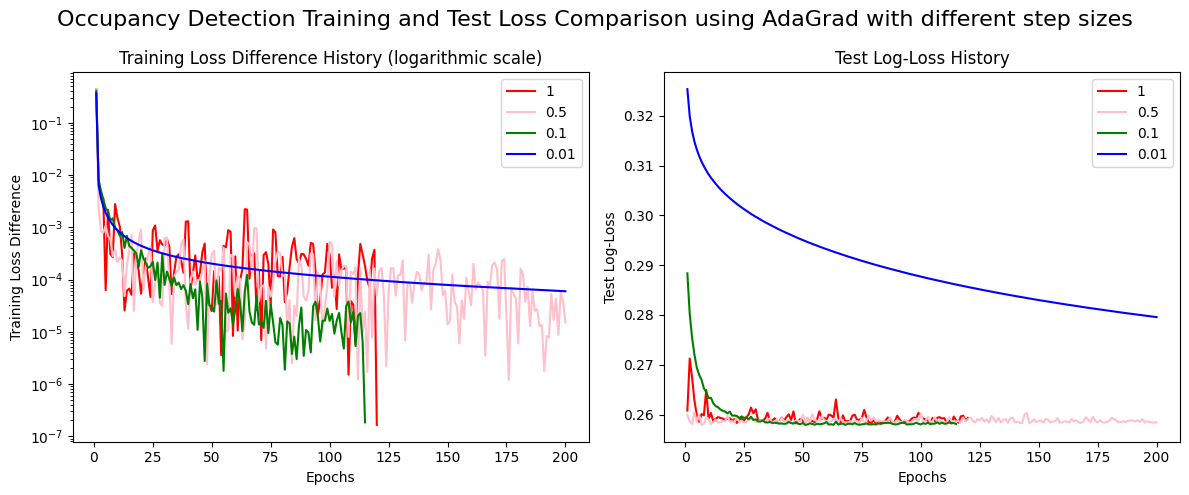

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(1, len(bank_eld_ada_grad_1) + 1), bank_eld_ada_grad_1, label='1', color="red")
axes[0].plot(range(1, len(bank_eld_ada_grad_05) + 1), bank_eld_ada_grad_05, label='0.5', color="pink")
axes[0].plot(range(1, len(bank_eld_ada_grad_01) + 1), bank_eld_ada_grad_01, label='0.1', color="green")
axes[0].plot(range(1, len(bank_eld_ada_grad_001) + 1), bank_eld_ada_grad_001, label='0.01', color="blue")
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss Difference')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_title('Training Loss Difference History (logarithmic scale)')

axes[1].plot(range(1, len(bank_tlh_ada_grad_1) + 1), bank_tlh_ada_grad_1, label='1', color="red")
axes[1].plot(range(1, len(bank_tlh_ada_grad_05) + 1), bank_tlh_ada_grad_05, label='0.5', color="pink")
axes[1].plot(range(1, len(bank_tlh_ada_grad_01) + 1), bank_tlh_ada_grad_01, label='0.1', color="green")
axes[1].plot(range(1, len(bank_tlh_ada_grad_001) + 1), bank_tlh_ada_grad_001, label='0.01', color="blue")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Test Log-Loss')
axes[1].legend()
axes[1].set_title('Test Log-Loss History')

fig.suptitle('Occupancy Detection Training and Test Loss Comparison using AdaGrad with different step sizes',
             fontsize=16)

plt.tight_layout()
plt.show()
plt.close()

In the Training Loss Difference History plot, we observe how the training loss decreases in the initial epochs for most learning rates tested (1, 0.5, 0.1, and 0.01). However, as expected, a smaller initial learning rate tends to show a more stable decline. All graphs except for the one with initial learning rate 0.01 seem to be unstable. The graph for 0.5 seems to oscillate around the one for 0.01. A decent balance between stability and convergence speed is the 0.1 graph. Maybe a value between 0.1 and 0.01 is optimal.

In the Test Log-Loss History plot, the test log-loss also reveals a trend of rapid initial improvement, followed by a gradual stabilization. The model with the initial learning rate of 0.1 reaches the lowest log-loss value, confirming the balance between speed and convergence quality. The models with learning rates of 1 and 0.5 fail to stabilize, wich is likely caused by the overshooting. The initial learning rate of 0.01 seems to be too high, since the corresponding graph is still declining after 200 epochs.


Does not seem to consistently reach 1e-6, so we increase the tolerance.

### Evaluation with Occupancy Detection Data

In [91]:
model_occupancy_ada_grad = LinearClassifierAdaGrad()
occupancy_eld_ada_grad_1, occupancy_tlh_ada_grad_1 = model_occupancy_ada_grad.fit(X_occupancy_train, y_occupancy_train,
                                                                                  X_occupancy_test, y_occupancy_test,
                                                                                  200, initial_learning_rate=1,
                                                                                  tolerance=1e-5)

occupancy_eld_ada_grad_05, occupancy_tlh_ada_grad_05 = model_occupancy_ada_grad.fit(X_occupancy_train,
                                                                                    y_occupancy_train, X_occupancy_test,
                                                                                    y_occupancy_test, 200,
                                                                                    initial_learning_rate=0.5,
                                                                                    tolerance=1e-5)

occupancy_eld_ada_grad_01, occupancy_tlh_ada_grad_01 = model_occupancy_ada_grad.fit(X_occupancy_train,
                                                                                    y_occupancy_train, X_occupancy_test,
                                                                                    y_occupancy_test, 200,
                                                                                    initial_learning_rate=0.1,
                                                                                    tolerance=1e-5)

occupancy_eld_ada_grad_001, occupancy_tlh_ada_grad_001 = model_occupancy_ada_grad.fit(X_occupancy_train,
                                                                                      y_occupancy_train,
                                                                                      X_occupancy_test,
                                                                                      y_occupancy_test, 200,
                                                                                      initial_learning_rate=0.01,
                                                                                      tolerance=1e-5)

Converged after 72 epochs.


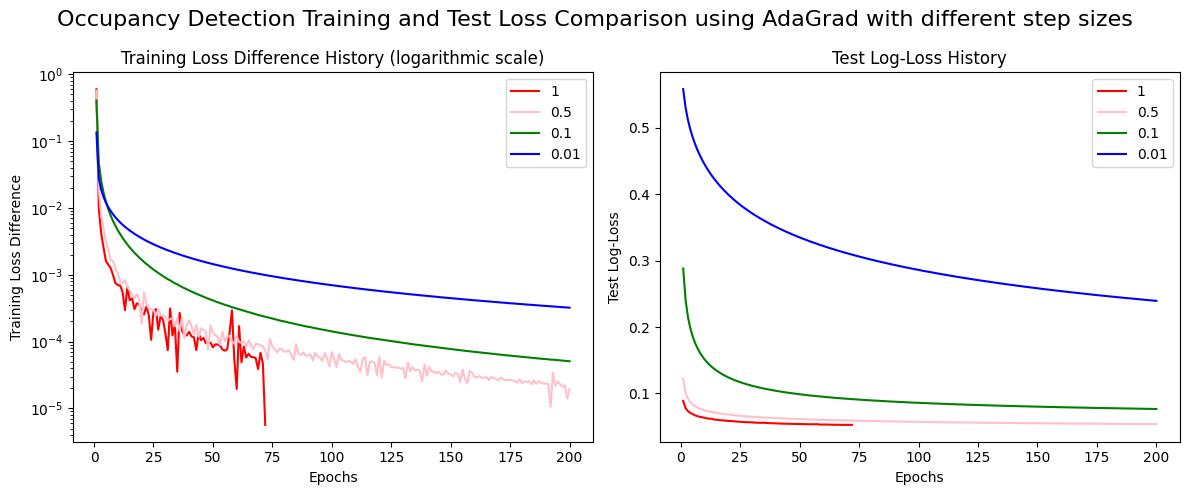

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(1, len(occupancy_eld_ada_grad_1) + 1), occupancy_eld_ada_grad_1, label='1', color="red")
axes[0].plot(range(1, len(occupancy_eld_ada_grad_05) + 1), occupancy_eld_ada_grad_05, label='0.5', color="pink")
axes[0].plot(range(1, len(occupancy_eld_ada_grad_01) + 1), occupancy_eld_ada_grad_01, label='0.1', color="green")
axes[0].plot(range(1, len(occupancy_eld_ada_grad_001) + 1), occupancy_eld_ada_grad_001, label='0.01', color="blue")
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Loss Difference')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_title('Training Loss Difference History (logarithmic scale)')

axes[1].plot(range(1, len(occupancy_tlh_ada_grad_1) + 1), occupancy_tlh_ada_grad_1, label='1', color="red")
axes[1].plot(range(1, len(occupancy_tlh_ada_grad_05) + 1), occupancy_tlh_ada_grad_05, label='0.5', color="pink")
axes[1].plot(range(1, len(occupancy_tlh_ada_grad_01) + 1), occupancy_tlh_ada_grad_01, label='0.1', color="green")
axes[1].plot(range(1, len(occupancy_tlh_ada_grad_001) + 1), occupancy_tlh_ada_grad_001, label='0.01', color="blue")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Test Log-Loss')
axes[1].legend()
axes[1].set_title('Test Log-Loss History')

fig.suptitle('Occupancy Detection Training and Test Loss Comparison using AdaGrad with different step sizes',
             fontsize=16)

plt.tight_layout()
plt.show()
plt.close()

In the Training Loss Difference History plot, we see that for learning rates greater than 0.1, the model oscillates. The learning rates 0.1 and 0.01 converge smoothly. The initial learning rate of 0.5 is quite promising, since it does not have as much oscillation as the one with learning rate 1, but it still manages to follow a very similar curve as the smooth ones, but a bit better values.

This can also be seen in the Test Log-Loss History plot, where the trend is largely similar. 0.01 is still declining, 0.1 seems to smoothly converge. The learning rate of 0.5 demonstrates a performance quite similar to the smoother convergence seen for lower rates, but reaches better loss values faster. Even the learning rate of 1 seems to converge comparably stable and with lower loss values.

In summary, while learning rates 0.1 and 0.01 provide smooth convergence, 0.5 reaches better values faster with minimal oscillation, making it a promising choice. Even learning rate 1 shows potential, achieving lower loss values albeit with higher instability initially.

### Comparison of AdaGrad and Bold Driver
Overall, Bold Driver is a better choice due to its simplicity and stability. Unlike AdaGrad, it does not require careful tuning of the initial learning rate. Bold Driver dynamically adjusts the learning rate during training, which leads to smoother convergence without significant oscillations. In contrast, AdaGrad's performance is highly dependent on the initial learning rate. Therefore, Bold Driver generally provides a more reliable and consistent convergence experience.